Notebook for using GloVe vectors combined with logistic regression

**Imports**

In [15]:

import json
import os
import pathlib

import numpy as np
import pandas as pd
import sklearn as sk

import pyplotterlib.standard.plotters as ppl

import shared_code_path
import misc_utils as miscUtilHelp
import model_wrappers as modelWrapHelp
import standard_pipes as stdPipeHelp
import train_pipes as trainPipeHelp


**Configuration Variables**

In [2]:
#
_rawDataFolder = os.path.abspath( os.path.join("..","..","..","raw_data") )
TRAIN_PATH = os.path.abspath( os.path.join(_rawDataFolder, "train.csv") )
TEST_PATH = os.path.abspath( os.path.join(_rawDataFolder, "test.csv") )

#
GLOVE_DIMS = [25, 50, 100]

#
SAVE_FOLDER = os.path.abspath( "glove_log_reg_save_folder" )
SUBMISSIONS_PATH = os.path.join(SAVE_FOLDER, "submissions.csv")

#
RERUN_HP_SEARCH = False
C_VALS = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]


In [3]:
np.random.seed(523423)

**Create save folder**

In [4]:
pathlib.Path(SAVE_FOLDER).mkdir(exist_ok=True)

**Import raw data**

In [5]:
RAW_TRAIN = pd.read_csv(TRAIN_PATH)
RAW_TRAIN.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


**Apply a standard text cleaning pipeline**

In [6]:
cleanPipe = stdPipeHelp.loadTextPreprocPipeA()
PROC_DATA = cleanPipe.fit_transform(RAW_TRAIN)

**Shuffle the frame**

In [7]:
PROC_DATA = PROC_DATA.sample(frac=1.0)

In [8]:
PROC_DATA.head(2)

,id,keyword,location,text,target
663,958,blaze,Mo.City,@beautiful_juic1 just letting you know,0
2086,2998,dead,NaN,@atchisonsean he is dead,0


**Create frames for each dimensionality of embedding**

In [9]:
%%prun
#7598209 function calls in 22.405 seconds
_embedPaths = [ os.path.join(_rawDataFolder, "glove.twitter.27B.{}d.txt".format(x)) for x in GLOVE_DIMS ]
_EMBED_DICTS = [miscUtilHelp.getGloveVectorsFromPath(inpPath) for inpPath in _embedPaths]

In [10]:
ALL_FRAMES = list()
for _embedDict in _EMBED_DICTS:
    _embedPipeline = stdPipeHelp.loadGloveTransformsPipeA(_embedDict)
    _currFrame = _embedPipeline.transform(PROC_DATA.copy())
    ALL_FRAMES.append(_currFrame)

In [11]:
ALL_FRAMES[0].head(2)

,id,keyword,location,text,target,max_enc_0,max_enc_1,max_enc_2,max_enc_3,max_enc_4,...,mean_enc_15,mean_enc_16,mean_enc_17,mean_enc_18,mean_enc_19,mean_enc_20,mean_enc_21,mean_enc_22,mean_enc_23,mean_enc_24
663,958,blaze,Mo.City,@beautiful_juic1 just letting you know,0,0.30260,1.5634,0.49681,0.65891,0.0,...,0.328964,0.240285,-0.739515,0.101460,-0.600307,0.600025,0.369602,0.101965,0.423355,-0.609163
2086,2998,dead,NaN,@atchisonsean he is dead,0,0.48301,0.3220,0.80542,0.19205,0.0,...,0.283317,0.349648,0.561750,-0.540043,-0.311870,0.671617,0.742180,0.297840,0.043673,0.129747


**Create a function to run (or load previously run results) for a grid search over n-dims and c-values**

In [12]:
def getGridSearchResults(prefixFeats, outPath, rerun=True, scaleVals=False):
    if scaleVals:
        trainPipe = trainPipeHelp.StandardScaler(ignoreCols=["target","text","keyword", "location"])
    else:
        trainPipe = None

    if rerun:
        #
        outResults = np.zeros( (len(GLOVE_DIMS),len(C_VALS)) )
        for dimIdx,gloveFrame in enumerate(ALL_FRAMES):
            for cIdx, cVal in enumerate(C_VALS):
                _currKwargs = {"featPrefix":prefixFeats, "C":cVal,
                               "trainPipe":trainPipe, "modelKwargs":{"max_iter":1000}}
                model = modelWrapHelp.LogRegressionClassifier(feats=list(), **_currKwargs)
                outResults[dimIdx][cIdx] = np.mean(sk.model_selection.cross_val_score(model, gloveFrame))

        #
        with open(outPath,"wt") as f:
            json.dump(outResults.tolist(),f)
    
    else:
        with open(outPath,"rt") as f:
            outResults = np.array(json.load(f))
    
    return outResults
            

**Run grid searchs with a few options for mapping a list of embedding vectors to a single vector**

In [13]:
#
_prefixFeatsAndOutPaths = [ (["min_"] , os.path.join(SAVE_FOLDER, "min_grid.json")),
                            (["max_"] , os.path.join(SAVE_FOLDER, "max_grid.json")),
                            (["mean_"], os.path.join(SAVE_FOLDER, "mean_grid.json")),
                            (["min_","max_","mean_"], os.path.join(SAVE_FOLDER, "min_max_mean.json"))
                          ]

SCORE_GRIDS = list()

for prefixes,outPath in _prefixFeatsAndOutPaths:
    _currScores = getGridSearchResults(prefixes, outPath, rerun=RERUN_HP_SEARCH, scaleVals=False)
    SCORE_GRIDS.append(_currScores)
    
    
    

**Visualize the grid search results**

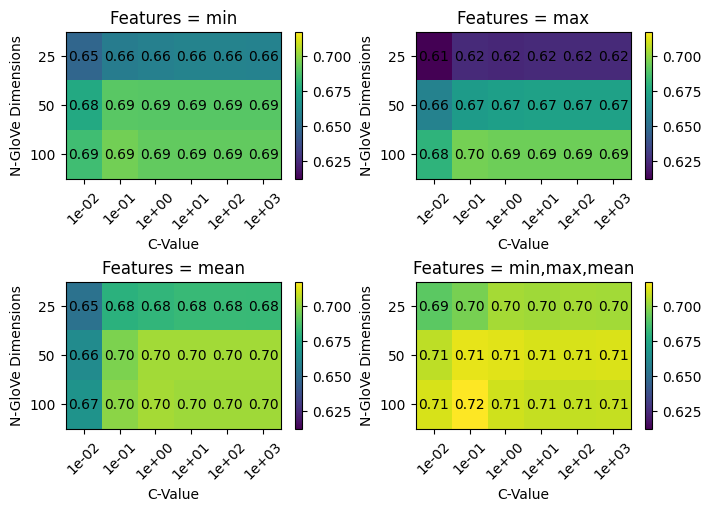

In [43]:
#Create a template heatmap plotter
_maxColor = max([np.max(x) for x in SCORE_GRIDS])
_minColor = min([np.min(x) for x in SCORE_GRIDS])
_currKwargs = {"annotateVals":True,
               "colorBarShow":True,
               "colorMapMaxVal":_maxColor,
               "colorMapMinVal":_minColor,
               "groupLabelsCols":["{:.0e}".format(x) for x in C_VALS],
               "groupLabelsColsRotation":45,
               "groupLabelsRows":GLOVE_DIMS,
               "xLabelStr":"C-Value",
               "yLabelStr":"N-GloVe Dimensions"
              }
heatmapTemplate = ppl.DiscreteHeatMapPlotter(**_currKwargs)


#Get individual discrete heat maps
plotters = list()
for (prefixes,_unused), scoreGrid in zip(_prefixFeatsAndOutPaths,SCORE_GRIDS):
    _titleStr = "Features = " + ",".join([x.replace("_","") for x in prefixes])
    _currKwargs = {"plotData":scoreGrid, "titleStr":_titleStr}
    _currPlotter = heatmapTemplate.createFactory(**_currKwargs)
    plotters.append(_currPlotter)

#Remove y-axis label from all but one
    
#Plot heat maps in a grid
_currKwargs = {"constrainedLayout":True,
               "figHeightPerRow":2.5,
               "figWidthPerCol":3.5,
               "nColsGrid":2
               }
gridPlotter = ppl.RectMultiPlotter(**_currKwargs)

_unused = gridPlotter.createPlot(plotters=plotters)

**Some conclusions**

1) Using features for the minimum/maximum/mean embedding all together gives the best results

2) If only mean XOR max XOR min are used, then the mean embedding gives the best results

3) 25-dimensional GloVe vectors give worse results than 50/100 dimensional

4) 100-dimensional vectors give similar (though sometimes slightly better) results than 50-dimensional

**Create a final model with the best hyperparameters**

In [48]:
cValue, useDims, usePrefixes = 1e-1, 100, ["mean_","max_","min_"]

_useEmbedDict = _EMBED_DICTS[ GLOVE_DIMS.index(useDims) ]
trainPipe = stdPipeHelp.loadGloveTransformsPipeA(_useEmbedDict)
_currKwargs = {"featPrefix":usePrefixes, "C":cValue, "modelKwargs":{"max_iter":1000}, "trainPipe":trainPipe}
MODEL = modelWrapHelp.LogRegressionClassifier(feats=list(), **_currKwargs)


**Have a quick look at the cross-val scores for training data**

In [50]:
cvScores = sk.model_selection.cross_val_score(MODEL, PROC_DATA)
print(cvScores)
print(np.mean(cvScores))

[0.75229358 0.73269231 0.73586654 0.72267389 0.70103093]
0.7289114500020141


**Retrain on the full dataset**

In [52]:
MODEL.fit(PROC_DATA)

LogRegressionClassifier(C=0.1, featPrefix=['mean_', 'max_', 'min_'], feats=[],
                        modelKwargs={'max_iter': 1000}, penalty='l2',
                        trainPipe=Pipeline(steps=[('Add min-GloVe embeddings',
                                                   <train_pipes.CreateMaxSentenceEncodings object at 0x7f1f2c7de950>),
                                                  ('Add max-GloVe embeddings',
                                                   <train_pipes.CreateMinSentenceEncodings object at 0x7f1f2c7dd7b0>),
                                                  ('Add mean-GloVe embeddings',
                                                   <train_pipes.CreateMeanSentenceEncodings object at 0x7f1f2c7defe0>)]))

**Double check our output model has good accuracy on the train set**

In [53]:
trainPred = MODEL.predict(PROC_DATA)
_deltaVals = [ abs(pred-act) for pred,act in zip(trainPred,PROC_DATA["target"].to_numpy()) ]
trainAcc = (len(_deltaVals)-sum(_deltaVals)) / len(_deltaVals)

In [54]:
print("Training accuracy = {}".format(trainAcc))

Training accuracy = 0.811326164874552


**Apply the model to the test data set**

In [55]:
RAW_TEST = pd.read_csv(TEST_PATH)
RAW_TEST.head(2)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."


In [57]:
testCleanPipe = stdPipeHelp.loadTextPreprocPipeA(removeDuplicateTweets=False)
testCleanPipe.fit(RAW_TRAIN)

#
PROC_TEST = testCleanPipe.transform(RAW_TEST)
PROC_TEST["target"] = MODEL.predict(PROC_TEST)
PROC_TEST.head(8)

,id,keyword,location,text,target
0,0,NaN,NaN,just happened a terrible car crash,1
1,2,NaN,NaN,"heard about #earthquake is different cities , ...",1
2,3,NaN,NaN,"there is a forest fire at spot pond , geese ar...",1
3,9,NaN,NaN,apocalypse lighting . #spokane #wildfires,1
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,1
5,12,NaN,NaN,we are shaking . it is an earthquake,1
6,21,NaN,NaN,they ' d probably still show more life than ar...,0
7,22,NaN,NaN,hey ! how are you ?,0


**Write our predictions to file in the correct format**

Kaggle Score = 0.79436

In [58]:
outFrame = PROC_TEST[["id","target"]]
outFrame.to_csv(SUBMISSIONS_PATH, index=False)

In [59]:
outFrame

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
